##  Proyecto 2:  Accidentes viales CDMX
### Métricas del modelo:



A continuación se muestran las métricas de nuestro mejor modelo.  

Después de varias pruebas, tanto el modelo _RandomForestClassifier_ como el _DecisionTree_ nos dieron resultados relativamente deficientes en prácticamente todas las métricas relevantes, por lo que el modelo final que estaremos evaluando es uno de **_Regresión Logística_**.  

In [3]:
#Importando lbirerías:

import pickle
import joblib
import sklearn
import random
import os
import pandas as pd
import numpy as np

from src.pipelines.magic_loop import load_transformation, filter_drop, \
                                      transformation_pipeline, train_test_split, NUM_VARS, CAT_VARS
##Cambiar la ubicación del magic_loop

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

Cargamos el modelo y los sets de prueba y entrenamiento:

In [6]:
X_train = pickle.load(open("../output/X_train_diciembre4.pkl", 'rb'))
y_train = pickle.load(open("../output/Y_train_diciembre4.pkl", 'rb'))
X_test = pickle.load(open("../output/X_test_diciembre4.pkl", 'rb'))
y_test = pickle.load(open("../output/Y_test_diciembre4.pkl", 'rb'))

In [7]:
model = joblib.load('../output/finalized_model.sav')

In [8]:
#Confirmando el tamaño de los sets de prueba y entrenamiento:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(967884, 62) (967884,) (414808, 62) (414808,)


In [9]:
#Confirmando el modelo cargado:
model

LogisticRegression(solver='sag')

Cargamos el dataframe generado en *Feature Engineering*:

In [11]:
# Nos mvemos un folder arriba
os.chdir("..")

In [12]:
path = os.getcwd()
df = load_transformation(path)

Opening feature engineering pickle from output path
Feature Engineering pickle successfully retrieved.


In [13]:
df.head()

,one_hot__x0_ALVARO OBREGON,one_hot__x0_AZCAPOTZALCO,one_hot__x0_BENITO JUAREZ,one_hot__x0_COYOACAN,one_hot__x0_CUAJIMALPA,one_hot__x0_CUAUHTEMOC,one_hot__x0_GUSTAVO A. MADERO,one_hot__x0_IZTACALCO,one_hot__x0_IZTAPALAPA,one_hot__x0_MAGDALENA CONTRERAS,...,dia_creacion,hora_simple,sin_hr,cos_hr,sin_month,cos_month,sin_day,cos_day,bool_llamada,label
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,13.0,-0.258819,-9.659258e-01,-2.449294e-16,1.0,0.433884,-0.900969,1.0,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,13.0,-0.258819,-9.659258e-01,-2.449294e-16,1.0,0.433884,-0.900969,1.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,31.0,13.0,-0.258819,-9.659258e-01,-2.449294e-16,1.0,0.433884,-0.900969,1.0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,18.0,-1.000000,-1.836970e-16,-2.449294e-16,1.0,0.433884,-0.900969,1.0,1
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,19.0,-0.965926,2.588190e-01,-2.449294e-16,1.0,0.433884,-0.900969,1.0,0


Generamos nuestras predicciones en el conjunto de prueba para la evaluación de métricas:

In [14]:
predicted_labels = model.predict(X_test)
predicted_scores = model.predict_proba(X_test)
predicted_probs = pd.DataFrame(predicted_scores, columns=["probability_0", "probability_1"])
#predicted_probs.head()

## Reporte de Métricas:

In [16]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predicted_labels)

0.8048687585581763

In [17]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [18]:
thresholds_2 = np.append(thresholds_2, 1)

In [88]:
#(precision.shape, recall.shape, thresholds_2.shape)

In [19]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, predicted_probs.probability_1, pos_label=1)

In [24]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.007078,0.195157,1.000000,0.326579,1.000000,0.999700,0.000300,0.000000
1,0.007100,0.195155,0.999988,0.326576,0.999988,0.999700,0.000300,0.000012
2,0.008389,0.195196,0.999988,0.326633,0.999988,0.999440,0.000560,0.000012
3,0.008395,0.195194,0.999975,0.326630,0.999975,0.999440,0.000560,0.000025
4,0.008405,0.195194,0.999975,0.326630,0.999975,0.999437,0.000563,0.000025
...,...,...,...,...,...,...,...,...
172283,0.667680,0.888889,0.000198,0.000395,0.000198,0.000006,0.999994,0.999802
172284,0.670937,0.941176,0.000198,0.000395,0.000198,0.000003,0.999997,0.999802
172285,0.671903,0.937500,0.000185,0.000371,0.000185,0.000003,0.999997,0.999815
172286,0.674224,1.000000,0.000185,0.000371,0.000185,0.000000,1.000000,0.999815


## Curva ROC:

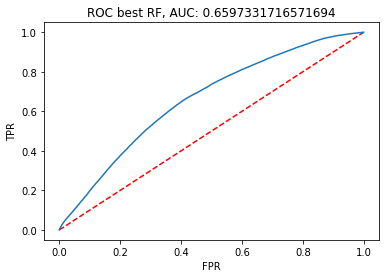

In [25]:
plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_probs.probability_1)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show();

## Matriz de confusión:

In [26]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_test, predicted_labels))
#Columnas = Predicción
#renglones = Realidad

,0,1
0,333679,196
1,80746,187


## Curva de precision y recall:

El promedio diario de llamadas se obtuvo de nuestro EDA-GEDA (554 llamadas diarias), y sabemos que contamos con 20 ambulancias al día.

In [27]:
ambulancias_disponibles_al_dia = 20.0
num_llamadas_al_dia = 554.0

In [28]:
k = ambulancias_disponibles_al_dia/num_llamadas_al_dia
print("El valor de k es igual a: ", k)

El valor de k es igual a:  0.036101083032490974


In [29]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_probs.probability_1, pos_label=1)

In [30]:
thresholds_2 = np.append(thresholds_2, 1)

In [31]:
(precision.shape, recall.shape, thresholds_2.shape)

((346813,), (346813,), (346813,))

In [32]:
from sklearn.metrics import precision_score

def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*(len(y_scores)-1))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return precision_score(y_true, y_pred)

In [33]:
from sklearn.metrics import recall_score
def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*(len(y_scores)-1))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return recall_score(y_true, y_pred)

In [35]:
def pr_k_curve(y_true, y_scores, save_target=None):
    k_values = list(np.arange(0.1, 1.1, 0.1))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
        ## get_top_k es una función que ordena los scores de
        ## mayor a menor y toma los k% primeros
        #top_k = get_top_k(y_scores, k)
        #top_k = y_scores
        # print(precision_at_k(y_true, y_scores, k))
        d['precision'] = precision_at_k(y_true, y_scores, k)#(top_k)
        d['recall'] = recall_at_k(y_true, y_scores, k)#(top_k, predictions)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    plt.legend()

    if save_target is not None:
        plt.savefig(save_target, dpi=300)
    else:
        plt.show

    return pr_k

In [36]:
precision_at_k(predicted_labels, y_test, k)

0.0023105531736127413

In [38]:
recall_at_k(predicted_labels, y_test, k)

0.48825065274151436

,k,precision,recall
0,0.1,0.002311,0.488251
1,0.2,0.000923,1.000000
2,0.3,0.000923,1.000000
3,0.4,0.000923,1.000000
4,0.5,0.000923,1.000000
5,0.6,0.000923,1.000000
6,0.7,0.000923,1.000000
7,0.8,0.000923,1.000000
8,0.9,0.000923,1.000000
9,1.0,0.000923,1.000000


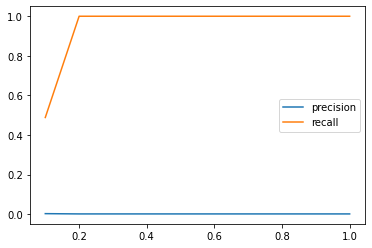

In [39]:
pr_k_curve(predicted_labels, y_test)

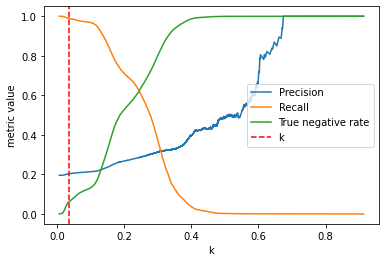

In [47]:
plt.plot(metrics_report.threshold, metrics_report.precision, label="Precision")
plt.plot(metrics_report.threshold, metrics_report.recall, label="Recall")
plt.plot(metrics_report.threshold, metrics_report.tnr, label="True negative rate")
plt.axvline(x=k, color="red", linestyle="--", label="k")
plt.legend(loc="best")
plt.xlabel("k")
plt.ylabel("metric value")
plt.show();

Como podemos ver, para el ratio k que obtenemos (sólo 20 ambulancias que se pueden enviar al día) , tenemos un recall a nuestro tope y una precisión baja. Podemos ver que si aumentara k, recall bajaría y la precisión aumentaría, sólo que en este contexto lo importante es el recall.


¿Qué métrica escogemos?

TP = El modelo dice que es llamada falsa,    y sí es llamada falsa.

TN = El modelo dice que es llamada no falsa, y no es llamada falsa**.

FP = El modelo dice que es llamada falsa,    y no es llamada falsa.

FN = El modelo dice que es llamada no falsa, y sí es llamada falsa.

Decidimos **TNR** dado que nos interesa ayudar a verificar que una llamada que el modelo dice que no es falsa, realmente no es falsa, ya que probablemente se necesite enviar una ambulancia.

De acuerdo a las métricas del negocio, les interesa tener un TNR mayor al 80%. Es decir, de 10 llamadas que el modelo dice que son llamadas legítimas, por lo menos 8 deben ser realmente legítimas.

In [48]:
negocio = metrics_report[metrics_report.tnr >= 0.8]
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
123604,0.299931,0.312883,0.375693,0.341424,0.375693,0.199997,0.800003,0.624307
123605,0.299932,0.312869,0.375669,0.341405,0.375669,0.199997,0.800003,0.624331
123606,0.299933,0.312876,0.375669,0.341409,0.375669,0.199991,0.800009,0.624331
123607,0.299933,0.312869,0.375656,0.341400,0.375656,0.199991,0.800009,0.624344
123608,0.299934,0.312872,0.375656,0.341402,0.375656,0.199988,0.800012,0.624344
...,...,...,...,...,...,...,...,...
172283,0.667680,0.888889,0.000198,0.000395,0.000198,0.000006,0.999994,0.999802
172284,0.670937,0.941176,0.000198,0.000395,0.000198,0.000003,0.999997,0.999802
172285,0.671903,0.937500,0.000185,0.000371,0.000185,0.000003,0.999997,0.999815
172286,0.674224,1.000000,0.000185,0.000371,0.000185,0.000000,1.000000,0.999815
